<a href="https://colab.research.google.com/github/inconw/ProjectPortfolio/blob/main/Lesson10_IngridConway.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# UW PCE DS 420- Homework 10
## Ingrid Conway
### November 30, 2020

In this homework, we take a sample of the IMDB dataset provided in TensorFlow Datasets to predict positive (1) or negative (0) sentiment. The data comes from http://ai.stanford.edu/~amaas/data/sentiment/ .

We start by creating a benchmark model. The benchmark model we create counts the number of positive words and subtracting from that the number of negative words in each review. This number is the score. If the score is negative, it has more negative words than positive word and is subsequently classified as negative.

We found that the accuracy of the model for predictions on our test set

We get the positive and negative words from the NLTK library.

In fact, a nice RNN is made here in the TensorFlow Tutorials:
https://www.tensorflow.org/tutorials/text/text_classification_rnn

We modify this to align with the Lesson 10 lab to use a simple RNN over a pandas sample.

We will have to implement a basic cleaning, tokenizing, and embedding.

In [ ]:
#!pip install tensorflow_datasets

In [ ]:
# Load Libraries
import os
import re
import string
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers
from tensorflow import keras

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# enable GPU for neural network training speedup
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')
print(device_name)


/device:GPU:0


### Here we load the data.

The data comes in a nice format for setting up a test-preprocessing pipeline of data in the TF Dataset type.

But we want to try to use Pandas, so we'll convert a portion of it into a dataframe.

First, we load the data into our tf.dataset() objects.

In [ ]:
# Setup the IMDB review data
# The IMDB review data contains 25,000 reviews in the train set. And also 25,000 reviews in the test set.

dataset, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

### Convert / Sample into Pandas.DataFrame

In [ ]:
# We can take up to 25,000 of each. But we'll take less for calculations to be easier.
train_count = 10000
test_count = 2000

# Setup Train DF
train_df = pd.DataFrame(columns=['review', 'label'])
for review, label in train_dataset.take(train_count):
    train_df = train_df.append({'review': review.numpy(), 'label': label.numpy()}, ignore_index=True)

# Setup Test DF
test_df = pd.DataFrame(columns=['review', 'label'])
for review, label in test_dataset.take(test_count):
    test_df = test_df.append({'review': review.numpy(), 'label': label.numpy()}, ignore_index=True)

# Change to strings from the 'b' - binary columns
train_df['review'] = train_df['review'].str.decode("utf-8")
test_df['review'] = test_df['review'].str.decode("utf-8")
    
# Check size and examples
print('Train shape: {}'.format(train_df.shape))
print('Test shape: {}'.format(test_df.shape))
train_df.head()

Train shape: (10000, 2)
Test shape: (2000, 2)


,review,label
0,This was an absolutely terrible movie. Don't b...,0
1,"I have been known to fall asleep during films,...",0
2,Mann photographs the Alberta Rocky Mountains i...,0
3,This is the kind of film for a snowy Sunday af...,1
4,"As others have mentioned, all the women that g...",1


In [ ]:
train_df['review'][0]   # label of 0 means negative review sentiment

"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."

### Check for target imbalance problems.

Next we check for the balance/ makeup of the target values to see if there exists any imbalance. There is a roughly 50-50 split between positive reviews and negative ones, so we don't need to worry about class imbalance.

In [ ]:
# Check target imbalance? 
print(train_df['label'].value_counts())
print(test_df['label'].value_counts())

1    5002
0    4998
Name: label, dtype: int64
1    1020
0     980
Name: label, dtype: int64


### Now we split the sets into train-validation-test

The data is already split into train-test. To make a validation set, we'll just split the test set in half.

In [ ]:
# Split into train-validation-test by taking half of the test set into validation
test_df, valid_df = train_test_split(test_df, test_size = 0.5)
test_df = test_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)

print('Test shape: {}'.format(test_df.shape))
print('Valid shape: {}'.format(valid_df.shape))
test_df.head()

Test shape: (1000, 2)
Valid shape: (1000, 2)


,review,label
0,This film held my interest from the beginning ...,1
1,"OK, Chuck Norris has shown up in many an enter...",0
2,I found this movie to be quite enjoyable and f...,1
3,The first time I saw this film I was a kid. I ...,1
4,I really liked the idea of traveling between d...,0


### Clean the text

# This was borrowed from the 'L10_Lab_NLP' class notebook.
# Lowercase everything


In [ ]:
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [ ]:
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk
nltk.download('wordnet')

stop_words = set(stopwords.words("english")) 
lemmatizer = WordNetLemmatizer()

# lemmatize converts all words to their base root word
# E.g., 'buses' --> 'bus', the singular
#       'singing' --> 'sing', the main root of the verb sing
# Example of list of words lemmatized with 'v', for converting verbs to present tense:
word_examples = ['was', 'sings', 'singing', 'sang', 'bus', 'buses', 'radii', 'radius']
[lemmatizer.lemmatize(token, 'v') for token in word_examples]

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


['be', 'sing', 'sing', 'sing', 'bus', 'bus', 'radii', 'radius']

In [ ]:
def text_process(my_string, remove_stops=True):
  # Lowercase (need to make sure it's a string because of garbage inputs...)
  sentence = str(my_string).lower()
  # Take non characters and replace with space.  This removes punctuation.
  sentence = re.sub(r'[^\w]', ' ', sentence)
  # Remove numbers
  sentence = re.sub(r'\d', ' ', sentence)
  # Remove extra white space
  sentence = ' '.join(sentence.split())
  # lemmatize converts words into their root words. E.g., all plural words into singular
  sentence = [lemmatizer.lemmatize(token) for token in sentence.split(" ")]
  # POS='v' means lemmatize verbs to their root verb present tense
  sentence = [lemmatizer.lemmatize(token, "v") for token in sentence]  
  # remove stop words, which don't convey as much meaning
  sentence = [word for word in sentence if not word in stop_words]
  sentence = " ".join(sentence)
  filtered_w_list = []
  return sentence

In [ ]:
# stop_words[0:20]
text_process('''Hi there. you are in your offices             working 

on your chair.''')

'hi office work chair'

# 3
### Create a rule-based benchmark (only need one)

Ideas:

- Load nltk's sentiment library.
- Create your own sentiment library.



In [ ]:
from nltk.tokenize import treebank
nltk.download('opinion_lexicon')

from nltk.corpus import opinion_lexicon

[nltk_data] Downloading package opinion_lexicon to /root/nltk_data...
[nltk_data]   Unzipping corpora/opinion_lexicon.zip.


In [ ]:
# Let's look at lexicon/dictionary
pos_set = set(opinion_lexicon.positive())
neg_set = set(opinion_lexicon.negative())

print('{:,} positive words:'.format(len(list(pos_set))))
print(list(pos_set)[:10])

print('{:,} negative words:'.format(len(list(neg_set))))
print(list(neg_set)[:10])

2,006 positive words:
['insightfully', 'feasible', 'whoooa', 'joy', 'distinguished', 'admiration', 'vibrant', 'rejoicingly', 'prodigious', 'eloquently']
4,783 negative words:
['louder', 'quarrellous', 'tarnishes', 'repulsively', 'injure', 'injustice', 'mistress', 'toll', 'corrode', 'abnormal']


In [ ]:
def sentiment_base(my_string):
    # Get words
    words = [w for w in word_tokenize(my_string)]
    # Get + and - scores:
    pos_score = sum([1 if w in pos_set else 0 for w in words])
    neg_score = sum([1 if w in neg_set else 0 for w in words])
    return pos_score - neg_score

In [ ]:
# Run for one example sentence
r = text_process("The movie was not bad.  It is the opposite of horrible.")
# our simple count of positive - negative words is not foolproof
sentiment_base( r  )

-2

In [ ]:
# Run for the validation set
def run_rule_sentiment(df):
  '''Run the rule based setiment analysis based on the number of positive
  words minuse the number of negative words.  Return the accuracy (what percent  it
  correctly predicts)'''
  rule_based = pd.DataFrame()
  rule_based['score'] = df['review'].apply( text_process ).apply( sentiment_base )
  rule_based['label'] = df['label']
  def is_correct(r):
    '''Returns True if the prediction is correct; False if the prediciton is wrong.
    r is the row of a dataframe that has a 'score' and 'label' column'''
    if r['score'] <= 0:
      if r['label'] == 1:
        return False
      else:
        return True
    else: # i.e., r['score'] > 0
      if r['label'] == 1: 
        return True
      else:
        return False
  rule_based['correct'] = rule_based.apply(is_correct, axis=1)
  #rule_based.head(20)
  accuracy = sum(rule_based['correct']) / len(rule_based)
  return accuracy  
accuracy_train      = run_rule_sentiment(train_df)
accuracy_validation = run_rule_sentiment(valid_df)
accuracy_test       = run_rule_sentiment(test_df)
print(f'Accuracy of train set predictions:      {accuracy_train}')
print(f'Accuracy of validation set predictions: {accuracy_validation}')
print(f'Accuracy of test set predictions:       {accuracy_test}')

Accuracy of train set predictions:      0.7264
Accuracy of validation set predictions: 0.728
Accuracy of test set predictions:       0.744


### Do some exploration of cleaned data.

What should we pick for the max_vocab size? (Look at # of unique words in train set, how many words appear > 1 times? > 3 times?

What should we pick for the max individual sequence length? (Look at # of total words in each entry).

> Note: there isn't a perfect answer to these. Pick what you feel is appropriate.

In [ ]:
# Count the number of times words are seen in ALL reviews in the training set
# with a Counter dictionary data type
from collections import Counter
count = Counter()
for r in train_df['review']:
  r = text_process(r)
  count.update(r.split(' '))


In [ ]:
print(f'''The total number of different words after text_process() run for ALL
moview reviews in the train_df is:   {len(count)}''')
# Example of using this Counter dictionary.  How many times is a particular word seen?
print(f'The number of times "movie" is seen in all reviews in training: {count["movie"]}')

The total number of different words after text_process() run for ALL
moview reviews in the train_df is:   38841
The number of times "movie" is seen in all reviews in training: 20658


In [ ]:
# loop through ALL words (w) and their counts of times seen (c)
words_few = {}  # empty dict of words that appear only few times.  will fill this dict next
for (w, c) in count.items():  
  if c<=3:
      words_few[w] = c
print(f'The number of words that appear three or fewer times in the entire colleciton of reviews: {len(words_few)}')
#list(count.items())[0:20]

The number of words that appear three or fewer times in the entire colleciton of reviews: 22632


In [ ]:
list(words_few.items())[0:20]

[('columbian', 1),
 ('conchita', 3),
 ('sette', 3),
 ('gunfighters', 2),
 ('microscopically', 2),
 ('gradation', 1),
 ('winningham', 3),
 ('oscillator', 1),
 ('vibrate', 3),
 ('herringbone', 1),
 ('emblazered', 1),
 ('ensweatered', 1),
 ('glamourous', 2),
 ('considerate', 3),
 ('pilcher', 2),
 ('polonia', 1),
 ('teacup', 2),
 ('nancherrow', 3),
 ('backlighting', 2),
 ('dewy', 3)]

In [ ]:
count.most_common(10)

[('br', 40435),
 ('movie', 20658),
 ('wa', 19514),
 ('film', 19441),
 ('one', 11109),
 ('make', 9433),
 ('like', 8968),
 ('see', 8331),
 ('get', 7220),
 ('ha', 6679)]

In [ ]:
# What is the length of the number of words in reviews after do text_process()?
train_df.head()
#def get_count(x):
#  return len( text_process( x ).split(' ') )

len( text_process("Here is my review of the bad movie").split(' ') )
rev_len = pd.DataFrame()   # dataframe of review lengths (empty now)
rev_len['NumWords'] = train_df['review'].apply(  
    lambda x: len( text_process( x ).split(' ') )  )

In [ ]:
rev_len.head()

,NumWords
0,69
1,55
2,78
3,46
4,38


Below we make a histogram to visualize the number of words across reviews. We subsequently cap the max review length at 130 words. We fiddled with the max_vocab_size, but settled at 6000.

,NumWords
count,10000.00000
mean,125.69560
std,94.64632
min,9.00000
25%,67.00000
50%,94.00000
75%,153.00000
max,1457.00000


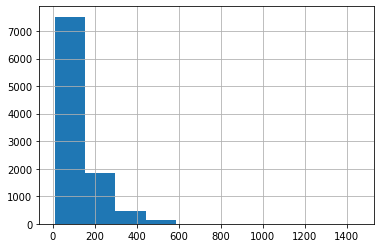

In [ ]:
rev_len['NumWords'].hist()
rev_len.describe()

In [ ]:
# Setup arrays
x_train = train_df['review'].apply(text_process).values
y_train = train_df['label'].astype(int).values
x_valid = valid_df['review'].apply(text_process).values
y_valid = valid_df['label'].astype(int).values
x_test = test_df['review'].apply(text_process).values
y_test = test_df['label'].astype(int).values

In [ ]:
# Setup a vocab embedding
max_vocab_size=6000 # Probably update this based on prior explorations
max_sequence_len=130 # Probably update this based on prior explorations

# Initialize our encoder
k_tokenizer = Tokenizer(num_words=max_vocab_size, oov_token='<unk>')

# Fit our tokenizer
k_tokenizer.fit_on_texts(x_train)

# Convert to sequences
x_train_seq = k_tokenizer.texts_to_sequences(x_train)
x_valid_seq = k_tokenizer.texts_to_sequences(x_valid)
x_test_seq = k_tokenizer.texts_to_sequences(x_test)

print(x_train_seq[0])
print(x_train[0])

[4, 375, 306, 3, 3743, 1107, 2821, 389, 1, 34, 50, 128, 251, 158, 85, 396, 17, 34, 37, 45, 993, 3, 567, 604, 3, 321, 3479, 79, 2062, 248, 983, 24, 1, 2907, 7, 293, 2584, 1862, 1, 1, 254, 3744, 3187, 39, 1231, 2821, 4, 84, 983, 723, 4978, 3, 4, 3480, 69, 103, 350, 3, 8, 837, 50, 8, 1107, 2821, 13, 160, 45, 1021, 322]
wa absolutely terrible movie lure christopher walken michael ironside great actor must simply worst role history even great act could redeem movie ridiculous storyline movie early ninety u propaganda piece pathetic scene columbian rebel make case revolution maria conchita alonso appear phony pseudo love affair walken wa nothing pathetic emotional plug movie wa devoid real mean disappoint movie like ruin actor like christopher walken good name could barely sit


In [ ]:
example_review = 'i love this movie so much snuffalufagus'

# Test encoding-> Any unknown word should get mapped to '1'
encoded_example = k_tokenizer.texts_to_sequences([example_review])
encoded_example

[[1, 39, 1, 3, 1, 27, 1]]

In [ ]:
# Add padding after sequences or cutoff to limit length.
# Padding can be before or after sequence. We want to pad w/ zeros after.
x_train_padded = pad_sequences(x_train_seq, padding='post', maxlen=max_sequence_len)
x_valid_padded = pad_sequences(x_valid_seq, padding='post', maxlen=max_sequence_len)
x_test_padded = pad_sequences(x_test_seq, padding='post', maxlen=max_sequence_len)

#print(x_train_padded[0])
#print(x_train_padded.shape)

# 4

Next, we set out building our recurrent neural network (RNN). The "recurrent" in our RNN means the output at the current time step becomes the input to the next time step. So at each point in the sequence, the model not only considers the current input, but also what it remembers about preceding elements(Koehrsen, 2018).



In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense , Input , LSTM , Embedding, Dropout , Activation, GRU, Flatten
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model, Sequential
from keras.layers import Convolution1D
from keras import initializers, regularizers, constraints, optimizers, layers


embed_size = 128
model = Sequential()
model.add(Embedding(max_vocab_size, embed_size))
model.add(Bidirectional(LSTM(32, return_sequences = True)))
model.add(GlobalMaxPool1D())
model.add(Dense(20, activation="relu"))
model.add(Dropout(0.05))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [ ]:
type(y_train[0])


numpy.int64

In [ ]:
batch_size = 100
epochs = 6
model.fit(x_train_padded, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2)

Epoch 1/6
80/80 [==============================] - 3s 36ms/step - loss: 0.5951 - accuracy: 0.6858 - val_loss: 0.3589 - val_accuracy: 0.8585
Epoch 2/6
80/80 [==============================] - 2s 25ms/step - loss: 0.2927 - accuracy: 0.8900 - val_loss: 0.3144 - val_accuracy: 0.8680
Epoch 3/6
80/80 [==============================] - 2s 25ms/step - loss: 0.1694 - accuracy: 0.9424 - val_loss: 0.3276 - val_accuracy: 0.8635
Epoch 4/6
80/80 [==============================] - 2s 26ms/step - loss: 0.1120 - accuracy: 0.9636 - val_loss: 0.3984 - val_accuracy: 0.8630
Epoch 5/6
80/80 [==============================] - 2s 26ms/step - loss: 0.0703 - accuracy: 0.9786 - val_loss: 0.4350 - val_accuracy: 0.8535
Epoch 6/6
80/80 [==============================] - 2s 26ms/step - loss: 0.0435 - accuracy: 0.9877 - val_loss: 0.6145 - val_accuracy: 0.8470


# 5 
# Evaluate Final Model.

In [ ]:
print("Evaluate the test data set.")
results = model.evaluate(x_test_padded, y_test, batch_size=batch_size )
print(f'test loss (binary_crossentropy): {results[0]}')
print(f'test accuracy:                   {results[1]}')

Evaluate the test data set.
10/10 [==============================] - 0s 9ms/step - loss: 0.6641 - accuracy: 0.8400
test loss (binary_crossentropy): 0.6640698909759521
test accuracy:                   0.8399999737739563


# 6
# Summary and Findings
## Text cleaning
  There was a great deal of text cleaning that had to be done before any text sentiment models to be built. For instance everything was made lowercase, number, punctuation, and extra white space removed, etc. We also removed stopwords from the reviews. Stopwords are ones like 'in', 'this', 'below', 'you', 'between', 'above', etc.--humans use them to communicate, but they're not useful to the computer. Last we used the WordNetLemmatizer to convert all words to their root words.

## Our basic rule-based sentiment model
  For our rule-based sentiment model, the AI determined a review's sentiment score by subtracting the number of negative words in a sequence from the number of positive in the same sequence. The model is simple, but not perfect- for instance, it has shown it's unreliable with reading over double-negatives. Still the simple model had 73% accuracy with the test data.

## RNN

  For our models we capped the 'max review length' at 130 words. We fiddled with the max_vocab_size, and settled at 6000. We started with 10 epochs, but determined we didn't need more than 6.
  Our final model had 83.99% accuracy on the test set, significantly more accurate than our simple rule-based sentiment model.

## *Models*

#######################
In our two models we create, we find that...

Examples of things to talk about:

- We tried a few cleaning processes. In fact we decided that we should treat apostrophes (') different than spaces. This is because...

- We found that after several tries, the RNN did finally converge to (insert metrics).

- We find that all the processing and RNN training only gives us a ??%-point gain over our simple rule based benchmark.

Works Cited

Koehrsen, Will. (Nov. 4, 2018). "Recurrent Neural Networks by Example in Python" towardsdatascience.com. Retrieved from:
https://towardsdatascience.com/recurrent-neural-networks-by-example-in-python-ffd204f99470

Many models adapted from 'L10_Lab_NLP' notebook.

> Indented block

